# 作家风格识别

<br>
<hr>

# 1.实验介绍

## 1.1实验背景

作家风格是作家在作品中表现出来的独特的审美风貌。  
通过分析作品的写作风格来识别作者这一研究有很多应用，比如可以帮助人们鉴定某些存在争议的文学作品的作者、判断文章是否剽窃他人作品等。  
作者识别其实就是一个文本分类的过程，文本分类就是在给定的分类体系下，根据文本的内容自动地确定文本所关联的类别。
写作风格学就是通过统计的方法来分析作者的写作风格，作者的写作风格是其在语言文字表达活动中的个人言语特征，是人格在语言活动中的某种体现。



## 1.2 实验要求
a）建立深度神经网络模型，对一段文本信息进行检测识别出该文本对应的作者。   
b）绘制深度神经网络模型图、绘制并分析学习曲线。  
c）用准确率等指标对模型进行评估。    



## 1.3 实验环境
可以使用基于 Python 分词库进行文本分词处理，使用 Numpy 库进行相关数值运算，使用 MindSpore 等框架建立深度学习模型等。

## 1.4 注意事项
+ Python 与 Python Package 的使用方式，可在右侧 `API文档` 中查阅。
+ 当右上角的『Python 3』长时间指示为运行中的时候，造成代码无法执行时，可以重新启动 Kernel 解决（左上角『Kernel』-『Restart Kernel』）。



## 1.5 参考资料
jieba：https://github.com/fxsjy/jieba   
Numpy：https://www.numpy.org/  
MindSpore: https://www.mindspore.cn

# 2.实验内容

## 2.1 介绍数据集

该数据集包含了 8438 个经典中国文学作品片段，对应文件分别以作家姓名的首字母大写命名。  
数据集中的作品片段分别取自 5 位作家的经典作品，分别是：

|序号|中文名|英文名|文本片段个数|
|--|--|--|--|
|1|鲁迅|LX| 1500 条 |
|2|莫言|MY| 2219 条 |
|3|钱钟书|QZS| 1419 条 |
|4|王小波|WXB| 1300 条 |
|5|张爱玲|ZAL| 2000 条 |

+ 其中截取的片段长度在 100~200 个中文字符不等
+ 数据集路径为 `dataset/`



In [4]:
# 导入相关包
import os
import time
import random
import jieba as jb
import numpy as np
import jieba.analyse
from matplotlib import pyplot as plt
from easydict import EasyDict as edict
from sklearn.preprocessing import LabelEncoder

from mindspore import nn
from mindspore import Model
from mindspore import Tensor
from mindspore import context
from mindspore import Parameter
from mindspore import  ParameterTuple
from mindspore.ops import operations as P
from mindspore.common import dtype as mstype
from mindspore_py.callback import EvalCallback
from mindspore_py.dataset import create_dataset
from mindspore.train.callback import LossMonitor
from mindspore.train.callback import ModelCheckpoint
from mindspore.common.initializer import initializer
from mindspore.train.callback import CheckpointConfig
from mindspore.train.serialization import load_checkpoint
from mindspore.train.serialization import load_param_into_net
from mindspore_py.prepocess import VocabularyProcessor
from mindspore_py.prepocess import convert_to_mindrecord

has_gpu = (os.system('command -v nvidia-smi') == 0)
print('Excuting with', 'GPU' if has_gpu else 'CPU', '.')
context.set_context(mode=context.GRAPH_MODE, device_target='GPU' if has_gpu else 'CPU')

Excuting with CPU .


读取数据集，保存在字典中

In [5]:
dataset = {}
path = "dataset/"
files= os.listdir(path)
for file in files:
    if not os.path.isdir(file) and not file[0] == '.': # 跳过隐藏文件和文件夹
        f = open(path + "/" + file, 'r',  encoding='UTF-8'); # 打开文件
        for line in f.readlines():
            dataset[line] = file[:-4]

数据集总共有 8438 个文本片段，现在展示其中的 10 个片段及其作者。

In [3]:
name_zh = {'LX': '鲁迅', 'MY':'莫言' , 'QZS':'钱钟书' ,'WXB':'王小波' ,'ZAL':'张爱玲'} 
for (k,v) in  list(dataset.items())[:10]:
    print(k,'---',name_zh[v])

几个少年辛苦奔走了十多年，暗地里一颗弹丸要了他的性命；几个少年一击不中，在监牢里身受一个多月的苦刑；几个少年怀着远志，忽然踪影全无，连尸首也不知那里去了。——“他们都在社会的冷笑恶骂迫害倾陷里过了一生；现在他们的坟墓也早在忘却里渐渐平塌下去了。
 --- 鲁迅
是的，你不解的。他一面点灯，一面冷静地说，“你的和我交往，我想，还正因为那时的哭哩。你不知道，这祖母，是我父亲的继母；他的生母，他三岁时候就死去了。他想着，默默地喝酒，吃完了一个熏鱼头。“那些往事，我原是不知道的。
 --- 鲁迅
这声音虽然极低，却很耳熟。看时又全没有人。站起来向外一望，那孔乙己便在柜台下对了门槛坐着。他脸上黑而且瘦，已经不成样子；穿一件破夹袄，盘着两腿，下面垫一个蒲包，用草绳在肩上挂住；见了我，又说道，“温一碗酒。
 --- 鲁迅
“阿，——纬甫，是你么？我万想不到会在这里遇见你。“阿阿，是你？我就邀他同坐，但他似乎略略踌躇之后，方才坐下来。我起先很以为奇，接着便有些悲伤，而且不快了。细看他相貌，也还是乱蓬蓬的须发；苍白的长方脸，然而衰瘦了。
 --- 鲁迅
我惶恐着，站起来说。“那么，我对你说。迅哥儿，你阔了，搬动又笨重，你还要什么这些破烂木器，让我拿去罢。我们小户人家，用得着。“我并没有阔哩。“阿呀呀，你放了道台⑼了，还说不阔？你现在有三房姨太太；出门便是八抬的大轿，还说不阔？
 --- 鲁迅
老三多两个孩子上学，老五也说他多用了公众的钱，气不过……。“这真是愈加闹不清了！月生失望似的说。“所以看见你们弟兄，沛君，我真是‘五体投地’。是的，我敢说，这决不是当面恭维的话。沛君不开口，望见听差的送进一件公文来，便迎上去接在手里。
 --- 鲁迅
我确有一个“籍”，也是各人各有一个的籍，不足为奇。但我是什么“系”呢自己想想，既非“研究系”，也非“交通系”，真不知怎么一回事。只好再精查，细想；终于也明白了，现在写它出来，庶几乎免得又有“流言”，以为我是黑籍的政客。
 --- 鲁迅
族长，近房，他的祖母的母家的亲丁，闲人，聚集了一屋子，豫计连殳的到来，应该已是入殓的时候了。〔2〕，因为逆料他关于一切丧葬仪式，是一定要改变新花样的。聚议之后，大概商定了三大条件，要他必行。一是穿白，二是跪拜，三是请和尚道士做法事〔3〕。
 --- 鲁迅
其实你只要读过四书就好，加以这样品格，已经很够做莘莘学子的表率

## 2.2 数据集预处理  
在做文本挖掘的时候，首先要做的预处理就是分词。  
英文单词天然有空格隔开容易按照空格分词，但是也有时候需要把多个单词做为一个分词，比如一些名词如 "New York" ，需要做为一个词看待。  
而中文由于没有空格，分词就是一个需要专门去解决的问题了。  
这里我们使用 jieba 包进行分词，使用**精确模式**、**全模式**和**搜索引擎模式**进行分词对比。  
更多方法参考：https://github.com/fxsjy/jieba   

In [3]:
# 精确模式分词
titles = [".".join(jb.cut(t, cut_all=False)) for t,_ in dataset.items()]
print("精确模式分词结果:\n",titles[0])

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.915 seconds.
Prefix dict has been built successfully.


精确模式分词结果:
 几个.少年.辛苦.奔走.了.十多年.，.暗地里.一颗.弹丸.要.了.他.的.性命.；.几个.少年.一击.不.中.，.在.监牢.里.身受.一个多月.的.苦刑.；.几个.少年.怀着.远志.，.忽然.踪影.全无.，.连.尸首.也.不知.那里.去.了.。.—.—.“.他们.都.在.社会.的.冷笑.恶骂.迫害.倾陷.里.过.了.一生.；.现在.他们.的.坟墓.也.早.在.忘却.里.渐渐.平.塌下去.了.。.



In [5]:
# 全模式分词
titles = [".".join(jb.cut(t, cut_all=True)) for t,_ in dataset.items()]
print("全模式分词结果:\n",titles[0])

全模式分词结果:
 几个.少年.辛苦.奔走.了.十多.十多年.多年.，.暗地.暗地里.地里.一颗.弹丸.要.了.他.的.性命.；.几个.少年.一.击.不中.，.在.监牢.里.身受.一个.一个多.一个多月.多月.的.苦刑.；.几个.少年.怀着.远志.，.忽然.踪影.全.无.，.连.尸首.也.不知.那里.去.了.。——“.他们.都.在.社会.的.冷笑.恶骂.迫害.倾陷.里.过.了.一生.；.现在.他们.的.坟墓.也.早在.忘却.里.渐渐.平.塌下.塌下去.下去.了.。.
.


In [6]:
# 搜索引擎模式分词
titles = [".".join(jb.cut_for_search(t)) for t,_ in dataset.items()]
print("搜索引擎模式分词结果:\n",titles[0])

搜索引擎模式分词结果:
 几个.少年.辛苦.奔走.了.十多.多年.十多年.，.暗地.地里.暗地里.一颗.弹丸.要.了.他.的.性命.；.几个.少年.一击.不.中.，.在.监牢.里.身受.一个.多月.一个多.一个多月.的.苦刑.；.几个.少年.怀着.远志.，.忽然.踪影.全无.，.连.尸首.也.不知.那里.去.了.。.—.—.“.他们.都.在.社会.的.冷笑.恶骂.迫害.倾陷.里.过.了.一生.；.现在.他们.的.坟墓.也.早.在.忘却.里.渐渐.平.塌下.下去.塌下去.了.。.



### 使用 TF-IDF 算法统计各个作品的关键词频率
TF-IDF（term frequency–inverse document frequency，词频-逆向文件频率）是一种用于信息检索与文本挖掘的常用加权技术。  
* TF-IDF是一种统计方法，用以评估一字词对于一个文件集或一个语料库中的其中一份文件的重要程度。字词的重要性随着它在文件中出现的次数成正比增加，但同时会随着它在语料库中出现的频率成反比下降。  
* TF-IDF的主要思想是：如果某个单词在一篇文章中出现的频率TF高，并且在其他文章中很少出现，则认为此词或者短语具有很好的类别区分能力，适合用来分类。  
这里我们使用 jieba 中的默认语料库来进行关键词抽取，并展示每位作者前 5 个关键词


In [7]:
# 将片段进行词频统计
str_full = {}
str_full['LX'] = ""
str_full['MY'] = ""
str_full['QZS'] = ""
str_full['WXB'] = ""
str_full['ZAL'] = ""

for (k,v) in dataset.items():
    str_full[v] += k

for (k,v) in str_full.items():
    print(k,":")
    for x, w in jb.analyse.extract_tags(v, topK=5, withWeight=True):
        print('%s %s' % (x, w))

LX :
阿Q 0.05379690966906414
没有 0.03501956188388567
一个 0.02659384736489112
知道 0.026370791166196325
什么 0.026117200927953624
MY :
西门 0.04035127611822447
父亲 0.03577176072663162
我们 0.02835442224012238
金龙 0.0274694159504008
一个 0.024059865345607147
QZS :
鸿渐 0.22516872869267315
辛楣 0.12453008658571695
小姐 0.06799326435687081
孙小姐 0.06114419277994029
柔嘉 0.05635906861892125
WXB :
李靖 0.05500282755382402
海鹰 0.048308857103309115
但是 0.03985236017697917
后来 0.028965598554340735
假如 0.026102821217101606
ZAL :
太太 0.05627531927572857
霓喜 0.02639100786806079
一个 0.02441434637731472
没有 0.022718951368287554
自己 0.019893114499557583


## 2.3 采用 Mindspore 建立一个简单的深度神经网络模型
通过 Mindspore 构建深度学习模型的步骤如下：
+ 定义模型——创建一个模型并添加配置层
+ 编译模型——指定损失函数和优化器，完成模型编译。
+ 训练模型——通过调用模型的 train() 函数来训练模型。
+ 模型预测——调用模型的 eval()或者 predict() 等函数对新数据进行预测。

### 2.3.1 配置超参

配置后续训练、验证、推理用到的超参。

In [18]:
# Network CONFIG
cfg = edict({
    'dataset_path': path,
    'mindrecord_path': 'results/mindrecord',
    'vocab_file': 'results/vocabulary.pkl',
    'vocab_size': 27000, # 必须大于等于下文的vocab.size()
    'num_classes': 5,
    'learning_rate': 0.00001,
    'num_epochs': 100,
    'batch_size': 64,
    'embed_size': 10,
    'embed_file': 'mindspore_py/embedding_weight.txt',
    'hidden_size': 32,
    'num_layers': 1,
    'max_document_length': 50,
    'min_frequency': 1,
    'ckpt_path': 'results/ckpt',
    'save_checkpoint_epochs': 1,
    'data_split': [0.7, 0.3]
})

### 2.3.2 读取数据集

首先需要读取数据集，记录每个片段的作者并保存。

In [7]:
def load_docs(path):
    """
    读取数据和标签
    :param path:数据集文件夹路径
    :return:返回读取的片段和对应的标签
    """
    sentences = [] # 片段
    target = [] # 作者
    
    # 定义lebel到数字的映射关系
    labels = {'LX': 0, 'MY': 1, 'QZS': 2, 'WXB': 3, 'ZAL': 4}

    files = os.listdir(path)
    for file in files:
        if not os.path.isdir(file):
            f = open(path + "/" + file, 'r', encoding='UTF-8');  # 打开文件
            for line in f.readlines():
                sentences.append(line)
                target.append(labels[file[:-4]])
    
    target = np.array(target)
    encoder = LabelEncoder()
    encoder.fit(target)
    encoded_target = encoder.transform(target)

    return sentences, encoded_target

对读取的片段进行分词，由于分词后的片段任然为中文词语组成的序列，需要创建词汇表，将每个中文词映射为一个数字。这里使用 VocabularyProcessor 创建词汇表。然后将数据转换并存储为 MindRecord 格式，用于接下来的训练和验证。

> "说明：" MindRecord 格式具有高效的读取性能，数据预处理并转换为 MindRecord 格式后，可永久存储，可通过 MindDataset 接口直接加载。

In [41]:
#数据预处理
def processing_data():
    docs, target = load_docs(cfg.dataset_path)
    # 使用jieba机精确模式分词
    docs = [".".join(jb.cut(t, cut_all=False)) for t in docs]
    # 创建词汇表
    vocab = VocabularyProcessor(max_document_length=cfg.max_document_length, min_frequency=cfg.min_frequency)
    vocab.fit(docs, cfg.vocab_file)
    word_id_list = vocab.transform(docs, cfg.vocab_file)
    convert_to_mindrecord(np.array(word_id_list).astype(np.int32), np.array(target).astype(np.int32), cfg.mindrecord_path)

processing_data()

[ERROR] ME(68:140069259036480,MainProcess):2020-11-26-22:13:06.350.770 [mindspore/mindrecord/shardwriter.py:53] Failed to open paths


results/mindrecord exists. Please make sure it is empty!
writing mindrecord into results/mindrecord/style.mindrecord


MRMOpenError: [MRMOpenError]: error_code: 1347690596, error_msg: MindRecord File could not open successfully.

### 2.3.3 建立深度学习模型

Mindspore的核心数据结构是 Cell，一种组织网络层的方式，重写`__init__`方法初始化算子和参数，重写`construct`方法将算子组织成网络结构。使用Mindspore创建一个简单的深度神经网络模型用于文本分类

In [41]:
def stack_lstm_default_state(batch_size, hidden_size, num_layers, bidirectional):
    """init default input."""
    num_directions = 2 if bidirectional else 1
    h_list = c_list = []
    for _ in range(num_layers):
        h_list.append(Tensor(np.zeros((num_directions, batch_size, hidden_size)).astype(np.float32)))
        c_list.append(Tensor(np.zeros((num_directions, batch_size, hidden_size)).astype(np.float32)))
    return tuple(h_list), tuple(c_list)

class StackLSTM(nn.Cell):
    def __init__(self,
                 input_size,
                 hidden_size,
                 num_layers=5,
                 has_bias=True,
                 batch_first=False,
                 dropout=0.3,
                 bidirectional=True):
        super(StackLSTM, self).__init__()
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.transpose = P.Transpose()
        num_directions = 2 if bidirectional else 1

        # 每层的input_size
        input_size_list = [input_size]
        for i in range(num_layers - 1):
            input_size_list.append(hidden_size * num_directions)

        # 初始化layers
        self.lstms = []
        for i in range(num_layers):
            self.lstms.append(nn.LSTMCell(input_size=input_size_list[i],
                                      hidden_size=hidden_size,
                                      has_bias=has_bias,
                                      batch_first=batch_first,
                                      bidirectional=bidirectional,
                                      dropout=dropout))

        # 初始化weights
        weights = []
        for i in range(num_layers):
            weight_size = (input_size_list[i] + hidden_size) * num_directions * hidden_size * 4
            if has_bias:
                bias_size = num_directions * hidden_size * 4
                if context.get_context('device_target') == 'GPU':
                    bias_size *= 2 # CPU nn.LSTMCell算子对x和h的两个bias做了合并，GPU中没做合并
                weight_size = weight_size + bias_size

            weights.append(Parameter(initializer('Uniform', (weight_size, 1, 1)), name="weight" + str(i)))

        self.weight = ParameterTuple(tuple(weights))

    def construct(self, x, hx):
        """construct"""
        if self.batch_first:
            x = self.transpose(x, (1, 0, 2))
        # stack lstm
        h, c = hx
        hn = cn = None
        for i in range(self.num_layers):
            x, hn, cn, _, _ = self.lstms[i](x, h[i], c[i], self.weight[i])
        if self.batch_first:
            x = self.transpose(x, (1, 0, 2))
        return x, (hn, cn)

class Net(nn.Cell):
    def __init__(self,
                 vocab_size,
                 embed_size,
                 hidden_size,
                 num_layers,
                 num_classes,
                 batch_size,
                 batch_first,
                 embedding_weight=None,
                 bidirectional=False):
        super(Net, self).__init__()
        if embedding_weight is None:
            self.embedding = nn.Embedding(vocab_size, embed_size)
        else:
            # MindSpore CPU暂不支持nn.Embedding的反向计算（即Embedding的训练），需加载已训练好的Embedding。
            self.embedding = nn.Embedding(vocab_size, embed_size, embedding_table=embedding_weight)
            self.embedding.embedding_table.requires_grad = False
        self.trans = P.Transpose()
        self.relu = nn.ReLU()
        self.encoder = StackLSTM(input_size=embed_size,
                               hidden_size=hidden_size,
                               num_layers=num_layers,
                               has_bias=False,
                               batch_first=batch_first,
                               bidirectional=bidirectional)
        self.h, self.c = stack_lstm_default_state(batch_size, hidden_size, num_layers, bidirectional)
        self.concat = P.Concat(1)
        self.reshape = P.Reshape()
        self.batch_size =batch_size
        self.decoder = nn.Dense(hidden_size * (2 if bidirectional else 1), num_classes)

    def construct(self, inputs):
        embeddings = self.embedding(inputs) #64 50 10
        embeddings = self.trans(embeddings, (1, 0, 2)) #50 64 10
        output, _ = self.encoder(embeddings, (self.h, self.c)) #50 64 32
        # 若把第0个时间步和最后一个时间步拼接起来，decoder的输入channel维度要乘2
        #encoding = self.concat((output[0], output[-1]))
        #outputs = self.decoder(encoding)
        #(max_step, batch, numclass)
        outputs = self.decoder(output[49])#(batch, numclass)
        return outputs

+ 选定损失函数、优化器，定义模型保存、评估的Callback, 使用MindSpore高级训练接口Model进行模型的训练、验证和保存。

In [42]:
def train():
    embedding_weight = None
    # MindSpore CPU 暂不支持nn.Embedding 的反向计算（即 Embedding 的训练），需加载已训练好的 Embedding。
    # MindSpore GPU 模式下，可以加载 Embedding 做初始值，获取更好的训练效果。
    if os.path.exists(cfg.embed_file):
        embedding_weight = Tensor(np.loadtxt(cfg.embed_file, dtype=np.float32))
        print('loaded', cfg.embed_file)
    elif context.get_context('device_target') == 'CPU':
        raise Exception(u'MindSpore CPU暂不支持nn.Embedding的训练，需加载已训练好的Embedding。')
    network = Net(vocab_size=cfg.vocab_size,
                  embed_size=cfg.embed_size,
                  hidden_size=cfg.hidden_size,
                  num_layers=cfg.num_layers,
                  num_classes=cfg.num_classes,
                  batch_size=cfg.batch_size,
                  batch_first=False,
                  embedding_weight=embedding_weight,
                  bidirectional=False)
    ds_train, ds_eval = create_dataset(cfg.mindrecord_path, cfg)
    loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    opt = nn.Momentum(params=network.trainable_params(), learning_rate=0.02, momentum=0.9)
    # nn.LazyAdam only works in GPU
    # opt = nn.LazyAdam(params=network.trainable_params(), learning_rate=cfg.learning_rate)
    model = Model(network, loss, opt, metrics={'acc', 'loss'})
    
    print("============== Starting Training ==============")
    config_ck = CheckpointConfig(
        save_checkpoint_steps=cfg.save_checkpoint_epochs * ds_train.get_dataset_size(),
        keep_checkpoint_max=cfg.num_epochs)
    ckpoint_cb = ModelCheckpoint(prefix='style', directory=cfg.ckpt_path, config=config_ck)
    history = {'epoch': [], 'train_loss': [], 'eval_loss': [], 'eval_acc': []}
    eval_cb = EvalCallback(model, ds_eval, history)
    cb = [eval_cb, ckpoint_cb]
    model.train(cfg.num_epochs, ds_train, callbacks=cb, dataset_sink_mode=False)
    print("============== Training Success ==============")
    return history


+ 模型训练过程和模型概况

In [43]:
# 开始时间
start = time.time()

# 训练模型，获取训练过程和训练后的模型
history = train()

print("模型训练总时长：", time.time()-start)

[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:26.312.149 [mindspore/dataset/engine/datasets.py:1558] Dataset is shuffled before split.


loaded mindspore_py/embedding_weight.txt
============== Starting Training ==============


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:27.943.410 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 1, train_loss: 1.591358, eval_loss: 1.585885, eval_acc: 0.267228


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:29.435.91 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 2, train_loss: 1.583873, eval_loss: 1.579563, eval_acc: 0.267228


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:29.945.812 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 3, train_loss: 1.570761, eval_loss: 1.559071, eval_acc: 0.319311


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:31.652.041 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 4, train_loss: 1.534492, eval_loss: 1.513359, eval_acc: 0.385016


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:33.417.202 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 5, train_loss: 1.475421, eval_loss: 1.454790, eval_acc: 0.399840


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:34.190.027 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 6, train_loss: 1.416536, eval_loss: 1.409265, eval_acc: 0.395433


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:35.507.23 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 7, train_loss: 1.371867, eval_loss: 1.374963, eval_acc: 0.409054


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:35.926.067 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 8, train_loss: 1.340283, eval_loss: 1.350917, eval_acc: 0.412660


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:38.876.457 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 9, train_loss: 1.318225, eval_loss: 1.334765, eval_acc: 0.414263


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:42.778.380 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 10, train_loss: 1.304775, eval_loss: 1.324454, eval_acc: 0.429487


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:43.694.118 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 11, train_loss: 1.294367, eval_loss: 1.317692, eval_acc: 0.444712


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:44.672.966 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 12, train_loss: 1.288365, eval_loss: 1.311932, eval_acc: 0.436699


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:45.680.616 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 13, train_loss: 1.282384, eval_loss: 1.307252, eval_acc: 0.446715


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:46.629.946 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 14, train_loss: 1.277975, eval_loss: 1.303875, eval_acc: 0.455128


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:47.674.619 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 15, train_loss: 1.274201, eval_loss: 1.300507, eval_acc: 0.456330


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:48.565.990 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 16, train_loss: 1.271635, eval_loss: 1.297550, eval_acc: 0.459936


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:49.577.524 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 17, train_loss: 1.268388, eval_loss: 1.294928, eval_acc: 0.459936


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:50.470.856 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 18, train_loss: 1.265901, eval_loss: 1.292640, eval_acc: 0.459135


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:51.384.554 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 19, train_loss: 1.261761, eval_loss: 1.290902, eval_acc: 0.471554


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:52.407.945 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 20, train_loss: 1.261078, eval_loss: 1.288445, eval_acc: 0.461138


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:53.287.027 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 21, train_loss: 1.258504, eval_loss: 1.286223, eval_acc: 0.462340


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:54.132.187 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 22, train_loss: 1.257188, eval_loss: 1.284644, eval_acc: 0.457131


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:55.339.89 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 23, train_loss: 1.253894, eval_loss: 1.283499, eval_acc: 0.467548


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:55.902.875 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 24, train_loss: 1.252481, eval_loss: 1.281331, eval_acc: 0.459535


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:56.763.689 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 25, train_loss: 1.251109, eval_loss: 1.279705, eval_acc: 0.457532


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:57.662.209 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 26, train_loss: 1.248985, eval_loss: 1.278009, eval_acc: 0.462740


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:58.513.001 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 27, train_loss: 1.247555, eval_loss: 1.277153, eval_acc: 0.459936


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:01:59.367.859 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 28, train_loss: 1.246339, eval_loss: 1.275700, eval_acc: 0.463942


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:00.291.965 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 29, train_loss: 1.245530, eval_loss: 1.274182, eval_acc: 0.459135


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:01.170.574 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 30, train_loss: 1.244321, eval_loss: 1.273222, eval_acc: 0.463942


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:02.110.35 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 31, train_loss: 1.243094, eval_loss: 1.272182, eval_acc: 0.469952


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:02.901.306 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 32, train_loss: 1.241664, eval_loss: 1.270949, eval_acc: 0.464343


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:04.487.293 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 33, train_loss: 1.239320, eval_loss: 1.269986, eval_acc: 0.471554


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:05.321.691 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 34, train_loss: 1.238480, eval_loss: 1.269152, eval_acc: 0.463942


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:06.214.983 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 35, train_loss: 1.236909, eval_loss: 1.267761, eval_acc: 0.463141


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:07.724.15 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 36, train_loss: 1.236778, eval_loss: 1.266605, eval_acc: 0.469551


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:07.975.692 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 37, train_loss: 1.235618, eval_loss: 1.265729, eval_acc: 0.468750


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:08.814.211 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 38, train_loss: 1.234114, eval_loss: 1.265564, eval_acc: 0.474760


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:09.851.293 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 39, train_loss: 1.232984, eval_loss: 1.263801, eval_acc: 0.467949


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:10.721.627 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 40, train_loss: 1.233408, eval_loss: 1.263097, eval_acc: 0.465946


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:11.578.329 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 41, train_loss: 1.232157, eval_loss: 1.261947, eval_acc: 0.477163


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:12.488.588 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 42, train_loss: 1.229500, eval_loss: 1.261064, eval_acc: 0.477163


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:13.336.975 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 43, train_loss: 1.230144, eval_loss: 1.260404, eval_acc: 0.476362


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:14.317.019 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 44, train_loss: 1.229176, eval_loss: 1.259714, eval_acc: 0.477564


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:15.181.468 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 45, train_loss: 1.226714, eval_loss: 1.259638, eval_acc: 0.475160


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:16.103.090 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 46, train_loss: 1.226404, eval_loss: 1.258219, eval_acc: 0.477564


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:16.965.280 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 47, train_loss: 1.226244, eval_loss: 1.257572, eval_acc: 0.475160


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:17.977.288 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 48, train_loss: 1.225369, eval_loss: 1.257155, eval_acc: 0.479167


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:18.955.690 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 49, train_loss: 1.225128, eval_loss: 1.256677, eval_acc: 0.474760


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:19.881.306 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 50, train_loss: 1.223305, eval_loss: 1.256198, eval_acc: 0.477163


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:20.762.716 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 51, train_loss: 1.223592, eval_loss: 1.255871, eval_acc: 0.477163


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:21.624.414 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 52, train_loss: 1.223278, eval_loss: 1.255541, eval_acc: 0.472356


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:22.462.853 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 53, train_loss: 1.222369, eval_loss: 1.254843, eval_acc: 0.475561


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:23.311.373 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 54, train_loss: 1.222607, eval_loss: 1.254702, eval_acc: 0.478365


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:24.445.511 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 55, train_loss: 1.222382, eval_loss: 1.254080, eval_acc: 0.473157


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:25.372.153 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 56, train_loss: 1.221436, eval_loss: 1.254148, eval_acc: 0.477564


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:26.239.986 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 57, train_loss: 1.221326, eval_loss: 1.253534, eval_acc: 0.475160


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:27.113.182 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 58, train_loss: 1.219748, eval_loss: 1.253201, eval_acc: 0.477163


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:27.965.292 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 59, train_loss: 1.221147, eval_loss: 1.253110, eval_acc: 0.473558


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:28.840.066 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 60, train_loss: 1.219287, eval_loss: 1.252730, eval_acc: 0.474760


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:29.724.468 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 61, train_loss: 1.219979, eval_loss: 1.252400, eval_acc: 0.473558


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:30.569.252 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 62, train_loss: 1.219710, eval_loss: 1.252261, eval_acc: 0.473558


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:31.428.741 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 63, train_loss: 1.218772, eval_loss: 1.252162, eval_acc: 0.479567


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:32.266.424 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 64, train_loss: 1.219829, eval_loss: 1.251697, eval_acc: 0.477965


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:33.101.301 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 65, train_loss: 1.218629, eval_loss: 1.251680, eval_acc: 0.474760


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:33.964.921 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 66, train_loss: 1.217842, eval_loss: 1.251807, eval_acc: 0.473958


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:34.835.929 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 67, train_loss: 1.217618, eval_loss: 1.251357, eval_acc: 0.474760


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:35.862.549 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 68, train_loss: 1.217642, eval_loss: 1.251055, eval_acc: 0.473958


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:36.705.518 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 69, train_loss: 1.217125, eval_loss: 1.250909, eval_acc: 0.472756


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:37.586.372 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 70, train_loss: 1.217757, eval_loss: 1.251034, eval_acc: 0.475160


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:38.455.244 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 71, train_loss: 1.216487, eval_loss: 1.250812, eval_acc: 0.478365


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:39.364.251 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 72, train_loss: 1.216271, eval_loss: 1.250838, eval_acc: 0.467548


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:40.227.229 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 73, train_loss: 1.217387, eval_loss: 1.250405, eval_acc: 0.472356


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:41.806.70 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 74, train_loss: 1.217274, eval_loss: 1.250511, eval_acc: 0.470353


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:41.960.382 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 75, train_loss: 1.215949, eval_loss: 1.250218, eval_acc: 0.473958


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:42.819.734 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 76, train_loss: 1.216839, eval_loss: 1.250180, eval_acc: 0.468750


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:43.722.091 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 77, train_loss: 1.216312, eval_loss: 1.249900, eval_acc: 0.473157


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:44.628.297 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 78, train_loss: 1.215650, eval_loss: 1.249754, eval_acc: 0.473558


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:45.550.146 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 79, train_loss: 1.216100, eval_loss: 1.249877, eval_acc: 0.469551


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:46.711.897 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 80, train_loss: 1.215261, eval_loss: 1.249953, eval_acc: 0.467147


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:47.603.225 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 81, train_loss: 1.215714, eval_loss: 1.249528, eval_acc: 0.474760


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:48.568.883 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 82, train_loss: 1.216153, eval_loss: 1.250151, eval_acc: 0.467949


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:49.543.844 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 83, train_loss: 1.214804, eval_loss: 1.249727, eval_acc: 0.468349


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:50.480.276 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 84, train_loss: 1.215391, eval_loss: 1.249341, eval_acc: 0.465545


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:51.506.596 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 85, train_loss: 1.214035, eval_loss: 1.249285, eval_acc: 0.477965


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:52.417.643 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 86, train_loss: 1.215525, eval_loss: 1.248976, eval_acc: 0.468750


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:53.361.805 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 87, train_loss: 1.214546, eval_loss: 1.249134, eval_acc: 0.466346


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:54.291.178 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 88, train_loss: 1.213795, eval_loss: 1.250026, eval_acc: 0.469551


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:55.159.613 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 89, train_loss: 1.214916, eval_loss: 1.248924, eval_acc: 0.469952


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:56.188.393 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 90, train_loss: 1.213353, eval_loss: 1.249007, eval_acc: 0.469952


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:57.143.728 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 91, train_loss: 1.214202, eval_loss: 1.248918, eval_acc: 0.466346


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:58.142.123 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 92, train_loss: 1.214107, eval_loss: 1.249208, eval_acc: 0.468750


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:02:59.142.584 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 93, train_loss: 1.213723, eval_loss: 1.248746, eval_acc: 0.465946


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:03:00.137.415 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 94, train_loss: 1.213416, eval_loss: 1.249007, eval_acc: 0.467949


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:03:01.323.08 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 95, train_loss: 1.214147, eval_loss: 1.248944, eval_acc: 0.469151


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:03:02.177.9 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 96, train_loss: 1.213215, eval_loss: 1.248544, eval_acc: 0.469151


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:03:02.888.246 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 97, train_loss: 1.214173, eval_loss: 1.248499, eval_acc: 0.475160


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:03:03.764.685 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 98, train_loss: 1.213305, eval_loss: 1.248311, eval_acc: 0.466346


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:03:04.727.532 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 99, train_loss: 1.211712, eval_loss: 1.248780, eval_acc: 0.468349


[WARNING] ME(67:140020707530560,MainProcess):2020-11-27-10:03:05.623.133 [mindspore/train/model.py:684] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


epoch: 100, train_loss: 1.212437, eval_loss: 1.248271, eval_acc: 0.469551
============== Training Success ==============
模型训练总时长： 100.00967168807983


+ 将不同epoch下的模型精度绘制出折线图并挑选最优模型Checkpoint。

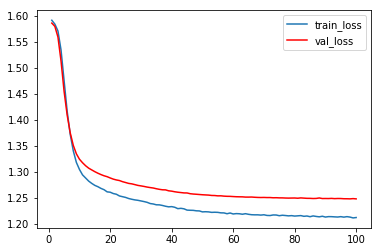

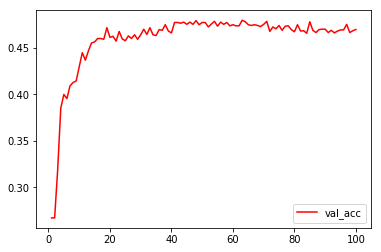

Chosen checkpoint is results/ckpt/style-10_105.ckpt


In [45]:
# 绘制模型训练过程曲线
plt.figure()
plt.plot(history['epoch'], history['train_loss'], label='train_loss')
plt.plot(history['epoch'], history['eval_loss'], 'r', label='val_loss')
plt.legend()
plt.savefig('results/loss.jpg')
plt.show()

plt.figure()
plt.plot(history['epoch'], history['eval_acc'], 'r', label = 'val_acc')
plt.legend()
plt.savefig('results/accuracy.jpg')
plt.show()

CKPT = os.path.join(cfg.ckpt_path, 'style-10_105.ckpt') # 挑选出最优模型Checkpoint

# CKPT = os.path.join(cfg.ckpt_path, 'style-%d_105.ckpt' % (np.argmax(history['eval_acc']) + 1)) # 挑选出最优模型Checkpoint
print("Chosen checkpoint is", CKPT)

## 2.4 加载模型并进行预测  

In [48]:
import numpy as np
from mindspore.train.serialization import load_checkpoint, load_param_into_net

def infer_data():
    # 使用鲁迅和张爱玲的片段测试
    sen1 = "阿Q住在未庄的土谷祠里，给人家打短工度日。虽然常常被村里人开玩笑，但内心他还反过来看不起村里人。他有一个缺点，就是头上有一块癞疮疤。所以只要被人说道有关疮疤的话题，他就发怒。大家觉得他的发怒很有趣，就更加开他的玩笑了。如果觉得对手弱，他就故意找茬吵架。但结果往往是输。"
    sen2 = "我于是日日盼望新年，新年到，闰土也就到了。好容易到了年末，有一日，母亲告诉我，闰土来了，我便飞跑的去看。他正在厨房里，紫色的圆脸，头戴一顶小毡帽，颈上套一个明晃晃的银项圈，这可见他的父亲十分爱他，怕他死去，所以在神佛面前许下愿心，用圈子将他套住了。"
    sen3 = "而他现在竟动手，很意外，难道真如市上所说，皇帝已经停了考⑤，不要秀才和举人了，因此赵家减了威风，因此他们也便小觑了他么？阿Q无可适从的站着。远远的走来了一个人，他的对头又到了。这也是阿Q最厌恶的一个人，就是钱太爷的大儿子。"
    sen4 = "我便只得回答道：跳蚤。跳蚤的来吮血，虽然可恶，而一声不响地就是一口，何等直截爽快。蚊子便不然了，一针叮进皮肤，自然还可以算得有点彻底的，但当未叮之前，要哼哼地发一篇大议论，却使人觉得讨厌。如果所哼的是在说明人血应该给它充饥的理由，那可更其讨厌了，幸而我不懂。"
    sen5 = "但终于走进自己的屋子里了，没有灯火；摸火柴点起来时，是异样的寂寞和空虚！正在错愕中，官太太便到窗外来叫我出去。“今天子君的父亲来到这里，将她接回去了。她很简单地说。这似乎又不是意料中的事，我便如脑后受了一击，无言地站着。"
    sen6 = "小寒道：“你瞧你，连外衣都汗潮了！也不知道你怎么忙来着！峰仪一面解外衣的钮子，一面向内室里走。众人见到了许峰仪，方才注意到钢琴上面一对暗金攒花照相架里的两张照片，一张是小寒的，一张是她父亲的。她父亲那张照片的下方，另附着一张着色的小照片，是一个粉光脂艳的十五年前的时装妇人，头发剃成男式，围着白丝巾，苹果绿水钻盘花短旗衫，手里携着玉色软缎钱袋，上面绣了一枝紫萝兰。"
    sen7 = "好在不是在她的范围内。潘汝良读书，有个坏脾气，手里握着铅笔，不肯闲着，老是在书头上画小人，他对于图画没有研究过，也不甚感兴趣，可是铅笔一着纸，一弯一弯的，不由自主就勾出一个人脸的侧影，永远是那一个脸，而且永远是向左。"
    sen8 = "潆芬笑道：“这人倒有趣得很！潆华道：“简直发痴！潆珠道：“真是的，哪个要他送？说来说去，嘴都说破了，就是回不掉他。路上走着，认得的人看见了，还让人说死了！为他受气，才犯不着呢？——知道他靠得住靠不住？不见得我跑去调查！"
    sen9 = "我要赶上去跟我们那位爱闹蹩扭的姑娘说两句话。众人道：“可是你总得有人送你回家！丹朱道：“不要紧，我叫传庆送我回去，也是一样的！众人还有些踌躇，丹朱笑道：“行！行！真的不要紧！说着，提起了她的衣服，就向传庆追来。"
    sen10 = "经过刚才的一场大闹，屋子里乱得很，也不知道什么时候桌上的一只茶杯给带翻了，滚到地下去，蜿蜒一线茶汁慢慢地流过来，五太太眼看着它像一条小蛇似的亮晶晶的在地板上爬着，向她的脚边爬过来，她的脚也不知怎么，依旧一动也不动。"
    sens = [sen1, sen2, sen3, sen4, sen5, sen6, sen7, sen8, sen9, sen10]
     #对输入文本进行预处理，使用同一个词汇表进行文本向量化
    sen_prosessed = [" ".join(jb.cut(sen, cut_all=True)) for sen in sens]
    vocab = VocabularyProcessor(max_document_length=cfg.max_document_length, min_frequency=cfg.min_frequency)
    word_id_list = vocab.transform(sen_prosessed, cfg.vocab_file)
    return np.array(word_id_list).astype(np.int32)

def infer(ckpt_path):
    # 定义int2string的映射关系
    labels = {0: '鲁迅', 1: '莫言', 2: '钱钟书', 3: '王小波', 4: '张爱玲'}
    data = infer_data()
    network = Net(vocab_size=cfg.vocab_size,
                  embed_size=cfg.embed_size,
                  hidden_size=cfg.hidden_size,
                  num_layers=cfg.num_layers,
                  num_classes=cfg.num_classes,
                  batch_size=data.shape[0],
                  batch_first=True,
                  bidirectional=False)
    model = Model(network)
    #加载模型
#     ckpt_path = 'results/ckpt/style-62_105.ckpt'
    param_dict = load_checkpoint(ckpt_path)
    # 可以保存训练好的Embedding，用于作为GPU版本的初始值，或者CPU版本直接使用
    np.savetxt("./results/embedding_weight.txt",param_dict["embedding.embedding_table"].asnumpy())
    load_param_into_net(network, param_dict)
    #输入模型进行预测
    result = model.predict(Tensor(data))
    predictions = np.argmax(result.asnumpy(), axis=1)
    for idx in predictions:
        print("预测是{}的文章".format(labels[idx]))

#输入指定的ckpt
ckpt_path = 'results/ckpt/style-10_105.ckpt'
infer(ckpt_path)

预测是鲁迅的文章
预测是王小波的文章
预测是鲁迅的文章
预测是鲁迅的文章
预测是鲁迅的文章
预测是张爱玲的文章
预测是钱钟书的文章
预测是张爱玲的文章
预测是张爱玲的文章
预测是张爱玲的文章


# 3.作业
**作业内容：** 根据一段中文文本（ 100~200 个中文字符），预测这段文本的作者。  


## 3.1 创建并训练模型
深度学习模型训练流程, 包含数据处理、创建模型、训练模型、模型保存、评价模型等。  
如果对训练出来的模型不满意, 你可以通过调整模型的参数等方法重新训练模型, 直至训练出你满意的模型。  
如果你对自己训练出来的模型非常满意, 则可以提交作业!  
可以使用任意一种平台支持的框架进行模型实现。

注意：

1. 你可以在我们准好的接口中实现深度学习模型（若使用可以修改除predict外的函数接口），也可以自己实现深度学习模型或改用其他框架实现,但需要满足predict函数的输入输出符合格式要求！
2. 写好代码后可以在 Py 文件中使用 GPU 进行模型训练。

===========================================实现自己的深度学习模型代码答题区===========================================

双击下方区域开始编写  **数据处理**、**创建模型**、**训练、评估和保存模型**等部分的代码，如果使用其他框架训练模型可以自行实现。  

In [ ]:
# Network CONFIG
cfg = edict({
    'dataset_path': path,
    'mindrecord_path': './mindrecord',
    'vocab_file': 'vocabulary.pkl',
    'vocab_size': 27000,
    'num_classes': 5,
    'learning_rate': 0.01,
    'num_epochs': 10,
    'batch_size': 64,
    'embed_size': 10,
    'embed_file': './mindspore_py/embedding_weight.txt',
    'hidden_size': 32,
    'num_layers': 1,
    'max_document_length': 50,
    'min_frequency': 1,
    'ckpt_path': './results/ckpt',
    'save_checkpoint_epochs': 1,
    'data_split': [0.8, 0.2]
})

def processing_data(data_path, validation_split = 0.3 ):
    """
    数据处理
    :data_path：数据集路径
    :validation_split：划分为验证集的比重
    :return：train_X,train_y,val_X,val_y 
    """
    # --------------- 在这里实现中文文本预处理，包含分词，建立词汇表,生成MindRecord文件等步骤 ------------------
    pass

    # --------------------------------------------------------------------------------------------
    

class Net(nn.Cell):
    """
    定义深度学习模型
    """
    # --------------------- 实现模型定义的代码 --------------------- 
    def __init__(self):
        pass
    
    def construct(self):
        pass 
    # -------------------------------------------------------------------------------------------- 


def train(cfg):
    """
    边训练边评估模型，并保存模型
    """
    # ----------------------- 边训练边验证模型等部分的代码 -----------------------
    pass
    
    # ---------------------------------------------------------------------------

def main():
    """
    深度学习模型训练流程,包含数据处理、创建模型、训练模型、模型保存、评价模型等。
    如果对训练出来的模型不满意,你可以通过调整模型的参数等方法重新训练模型,直至训练出你满意的模型。
    如果你对自己训练出来的模型非常满意,则可以提交作业!
    :return:
    """
    # 获取数据、并进行预处理
    # processing_data(cfg)

    # 创建、训练和保存模型
    # train(cfg)

if __name__ == '__main__':
    main()

## 3.2 模型预测


注意：
1. 点击左侧栏`提交作业`后点击`生成文件`则只需勾选 `predict()` 函数的cell，即【**模型预测代码答题区域**】的 cell。
2. 请导入必要的包和第三方库 (包括此文件中曾经导入过的)。
3. 请加载你认为训练最佳的模型，即请按要求填写模型路径。
4. `predict()`函数的输入和输出请不要改动。
5. 作业测试时记得填写你的模型路径及名称, 如果采用 [离线任务](https://momodel.cn/docs/#/zh-cn/%E5%9C%A8GPU%E6%88%96CPU%E8%B5%84%E6%BA%90%E4%B8%8A%E8%AE%AD%E7%BB%83%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E6%A8%A1%E5%9E%8B) 请将模型保存在 **results** 文件夹下。

=================================  **提交 Notebook 训练模型结果数据处理参考示范**  =================================
<br>

In [ ]:
# 导入相关包
import os
import time
import random
import warnings
import jieba as jb
import numpy as np
import jieba.analyse
from easydict import EasyDict as edict

from mindspore import nn
from mindspore import Model
from mindspore import Tensor
from mindspore import context
from mindspore import Parameter
from mindspore import ParameterTuple
from mindspore.ops import operations as P
from mindspore.common import dtype as mstype
from mindspore.common.initializer import initializer
from mindspore.train.serialization import load_checkpoint
from mindspore.train.serialization import load_param_into_net
from mindspore_py.prepocess import VocabularyProcessor

warnings.filterwarnings('ignore')
has_gpu = (os.system('command -v nvidia-smi') == 0)
print('Excuting with', 'GPU' if has_gpu else 'CPU', '.')
context.set_context(mode=context.GRAPH_MODE, device_target='GPU' if has_gpu else 'CPU')

path = 'dataset/'
cfg = edict({
    'vocab_file': 'results/vocabulary.pkl',
    'vocab_size': 27000,
    'num_classes': 5,
    'batch_size': 64,
    'embed_size': 10,
    'embed_file': 'mindspore_py/embedding_weight.txt',
    'hidden_size': 32,
    'num_layers': 1,
    'max_document_length': 50,
    'min_frequency': 1,
    'ckpt_path': 'results',
})

In [ ]:
# =========================  Notebook 训练模型网络结构参考示范  =========================
def stack_lstm_default_state(batch_size, hidden_size, num_layers, bidirectional):
    """init default input."""
    num_directions = 2 if bidirectional else 1
    h_list = c_list = []
    for _ in range(num_layers):
        h_list.append(Tensor(np.zeros((num_directions, batch_size, hidden_size)).astype(np.float32)))
        c_list.append(Tensor(np.zeros((num_directions, batch_size, hidden_size)).astype(np.float32)))
    return tuple(h_list), tuple(c_list)

class StackLSTM(nn.Cell):
    def __init__(self,
                 input_size,
                 hidden_size,
                 num_layers=1,
                 has_bias=True,
                 batch_first=False,
                 dropout=0.0,
                 bidirectional=False):
        super(StackLSTM, self).__init__()
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.transpose = P.Transpose()
        num_directions = 2 if bidirectional else 1

        # 每层的input_size
        input_size_list = [input_size]
        for i in range(num_layers - 1):
            input_size_list.append(hidden_size * num_directions)

        # 初始化layers
        self.lstms = []
        for i in range(num_layers):
            self.lstms.append(nn.LSTMCell(input_size=input_size_list[i],
                                      hidden_size=hidden_size,
                                      has_bias=has_bias,
                                      batch_first=batch_first,
                                      bidirectional=bidirectional,
                                      dropout=dropout))

        # 初始化weights
        weights = []
        for i in range(num_layers):
            weight_size = (input_size_list[i] + hidden_size) * num_directions * hidden_size * 4
            if has_bias:
                bias_size = num_directions * hidden_size * 4
                if context.get_context('device_target') == 'GPU':
                    bias_size *= 2 # CPU nn.LSTMCell算子对x和h的两个bias做了合并，GPU中没做合并
                weight_size = weight_size + bias_size

            weights.append(Parameter(initializer('Uniform', (weight_size, 1, 1)), name="weight" + str(i)))

        self.weight = ParameterTuple(tuple(weights))

    def construct(self, x, hx):
        """construct"""
        if self.batch_first:
            x = self.transpose(x, (1, 0, 2))
        # stack lstm
        h, c = hx
        hn = cn = None
        for i in range(self.num_layers):
            x, hn, cn, _, _ = self.lstms[i](x, h[i], c[i], self.weight[i])
        if self.batch_first:
            x = self.transpose(x, (1, 0, 2))
        return x, (hn, cn)

class Net(nn.Cell):
    def __init__(self,
                 vocab_size,
                 embed_size,
                 hidden_size,
                 num_layers,
                 num_classes,
                 batch_size,
                 batch_first,
                 embedding_weight=None,
                 bidirectional=False):
        super(Net, self).__init__()
        if embedding_weight is None:
            self.embedding = nn.Embedding(vocab_size, embed_size)
        else:
            # MindSpore CPU暂不支持nn.Embedding的反向计算（即Embedding的训练），需加载已训练好的Embedding。
            self.embedding = nn.Embedding(vocab_size, embed_size, embedding_table=embedding_weight)
            self.embedding.embedding_table.requires_grad = False
        self.trans = P.Transpose()
        self.relu = nn.ReLU()
        self.encoder = StackLSTM(input_size=embed_size,
                               hidden_size=hidden_size,
                               num_layers=num_layers,
                               has_bias=False,
                               batch_first=batch_first,
                               bidirectional=bidirectional)
        self.h, self.c = stack_lstm_default_state(batch_size, hidden_size, num_layers, bidirectional)
        self.concat = P.Concat(1)
        self.reshape = P.Reshape()
        self.batch_size =batch_size
        self.decoder = nn.Dense(hidden_size * (2 if bidirectional else 1), num_classes)

    def construct(self, inputs):
        embeddings = self.embedding(inputs) #64 50 10
        embeddings = self.trans(embeddings, (1, 0, 2)) #50 64 10
        output, _ = self.encoder(embeddings, (self.h, self.c)) #50 64 32
        # 若把第0个时间步和最后一个时间步拼接起来，decoder的输入channel维度要乘2
        #encoding = self.concat((output[0], output[-1]))
        #outputs = self.decoder(encoding)
        #(max_step, batch, numclass)
        outputs = self.decoder(output[49])#(batch, numclass)
        return outputs

===========================================  **模型预测代码答题区域**  ===========================================  
在下方的代码块中编写 **模型预测** 部分的代码，请勿在别的位置作答

In [ ]:
# ------------------ 请加载您最满意模型的网络结构 ---------------------------
# 加载 notebook 中网络模型，以下代码为示范样例，可自行修改删除
network = Net(vocab_size=cfg.vocab_size,
              embed_size=cfg.embed_size,
              hidden_size=cfg.hidden_size,
              num_layers=cfg.num_layers,
              num_classes=cfg.num_classes,
              batch_size=1,
              batch_first=True,
              bidirectional=False)
model = Model(network)

# -------------------------- 请加载您最满意的模型 ---------------------------
# 加载模型(请加载你认为的最佳模型)
# 加载模型,加载请注意 model_path 是相对路径, 与当前文件同级。
# 如果你的模型是在 results 文件夹下的 demo.ckpt 模型，则 model_path = 'results/demo.ckpt'

ckpt_path = 'results/ckpt/style_2-62_105.ckpt'
# 加载模型
param_dict = load_checkpoint(ckpt_path)
load_param_into_net(network, param_dict)

# ----------------------模型预测，注意不要修改函数的输入输出---------------------------
def predict(text):
    """
    :param text: 中文字符串
    :return: 字符串格式的作者名缩写
    """
    # ------------------ 实现预测部分的代码，以下样例可代码自行删除 --------------------
    # 整数到作者名的映射
    labels = {0: 'LX', 1: 'MY', 2: 'QZS', 3: 'WXB', 4: 'ZAL'}
    # 对输入文本进行预处理，使用同一个词汇表进行文本向量化
    sen_processed = [" ".join(jb.cut(text, cut_all=True))]
    vocab = VocabularyProcessor(max_document_length=cfg.max_document_length,
                                min_frequency=cfg.min_frequency)
    word_id_list = vocab.transform(sen_processed, cfg.vocab_file)
    data = np.array(word_id_list).astype(np.int32)
    result = model.predict(Tensor(data))
    idx = np.argmax(result.asnumpy()[0])
    # --------------------------------------------------------------------------
    return labels[idx]

In [ ]:
sen = "我听到一声尖叫，感觉到蹄爪戳在了一个富有弹性的东西上。定睛一看，不由怒火中烧。原来，趁着我不在，隔壁那个野杂种——沂蒙山猪刁小三，正舒坦地趴在我的绣榻上睡觉。我的身体顿时痒了起来，我的目光顿时凶了起来。"
predict(sen)